In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

In [2]:
## I was getting a bunch of future warnings; didn't like the red.

import warnings
warnings.filterwarnings('ignore')

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [4]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1980-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1980-01-02,4242.0,4260.0,4240.0,4259.0,NaN,4259.0,909.0,2255.0
1980-01-03,4265.0,4278.0,4239.0,4243.0,NaN,4243.0,797.0,2195.0
1980-01-04,4279.0,4336.0,4279.0,4334.0,NaN,4334.0,3037.0,3784.0
1980-01-07,4336.0,4395.0,4336.0,4392.0,NaN,4392.0,3083.0,5106.0
1980-01-08,4319.0,4329.0,4297.0,4299.0,NaN,4299.0,3242.0,4474.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

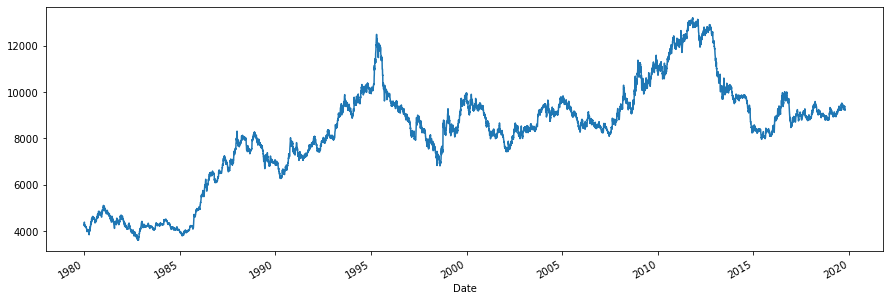

In [5]:
# Plot just the "Settle" column from the dataframe:
## I need to isolate the Settle column
## Creating a new DF with *just* 'Settle'
## Plotting new DF

yen_futures_settle = yen_futures['Settle']

# I realize that this is a series, not a df
yen_futures_settle.plot(figsize = (15,5))

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [6]:
## Getting some errors, I split this cell to isolate the import for troubleshooting.
import statsmodels.api as sm

In [7]:
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
## I had to go back and find the Hodrick-Prescott syntax in the instructor Activities, mine was wrong.

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures_settle)

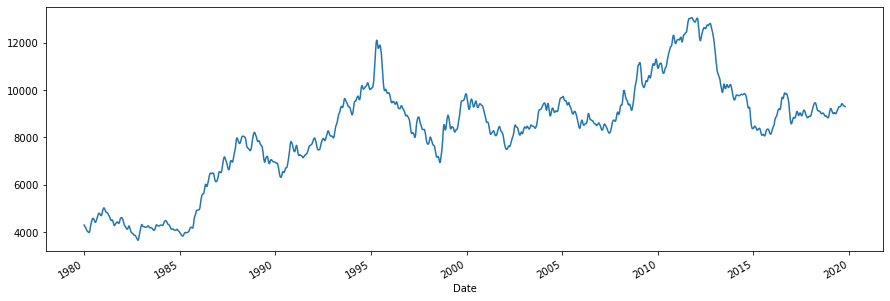

In [8]:
## Plotting the trend.
ts_trend.plot(figsize = (15,5))

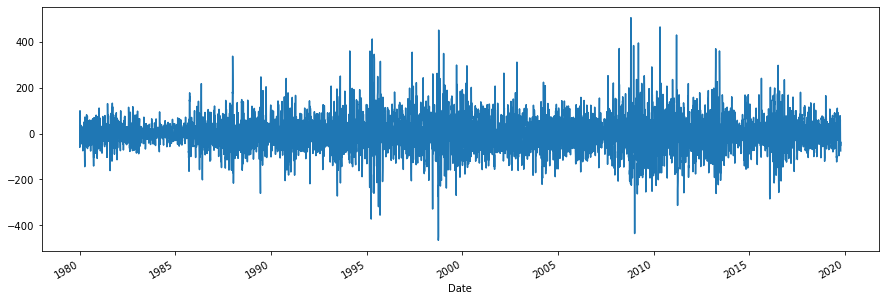

In [9]:
## Plotting the noise.
ts_noise.plot(figsize = (15,5))

In [10]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
## setting up new df, yen_noise_trend_df
## basedon on Genki's suggestion, I switched the order of trend and noise

yen_noise_trend_df = yen_futures_settle.to_frame()
yen_noise_trend_df["yen_trend"] = ts_trend
yen_noise_trend_df["yen_noise"] = ts_noise

yen_noise_trend_df

,Settle,yen_trend,yen_noise
Date,,,
1980-01-02,4259.0,4308.200558,-49.200558
1980-01-03,4243.0,4303.120872,-60.120872
1980-01-04,4334.0,4298.010434,35.989566
1980-01-07,4392.0,4292.800921,99.199079
1980-01-08,4299.0,4287.446499,11.553501
...,...,...,...
2019-10-09,9338.0,9313.060753,24.939247
2019-10-10,9303.5,9309.368559,-5.868559
2019-10-11,9251.0,9305.454594,-54.454594


In [11]:
# Plot the Settle Price vs. the Trend for 2015 to the present
## First I need to isolate the 2015+ data
yen_noise_trend_df2015 = yen_noise_trend_df.loc["2015-01-01":, :]
yen_noise_trend_df2015.head()

,Settle,yen_trend,yen_noise
Date,,,
2015-01-02,8315.0,8394.686404,-79.686404
2015-01-05,8371.0,8401.395762,-30.395762
2015-01-06,8435.0,8408.585597,26.414403
2015-01-07,8412.0,8416.089059,-4.089059
2015-01-08,8360.0,8423.755805,-63.755805


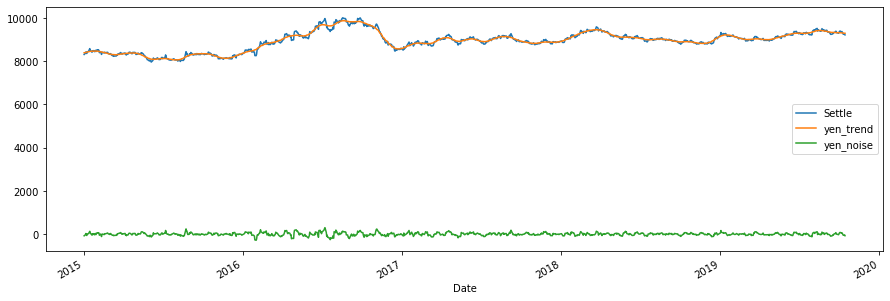

In [12]:
## Now I want to plot the new df2015
yen_noise_trend_df2015.plot(figsize=(15,5))

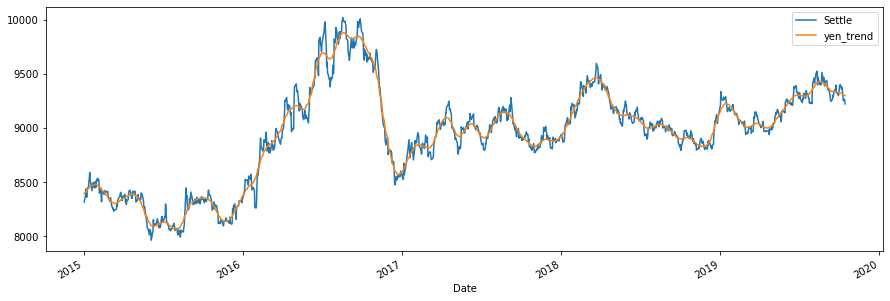

In [13]:
## I need to plot everything *but* the yen_noise
## adding y labels, excluding yen_noise
yen_noise_trend_df2015.plot(y=['Settle','yen_trend'], figsize=(15,5))

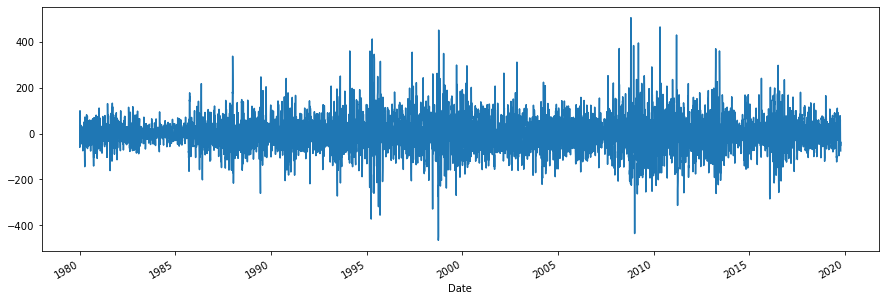

In [14]:
# Plot the Settle Noise
## Plotting the noise.
ts_noise.plot(figsize = (15,5))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [15]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
## This is all in the starter code.

returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [16]:
## Splitting the cell here in case I need to troubleshoot imports later.
import statsmodels.api as sm

In [17]:
## From the student dos.
from statsmodels.tsa.arima_model import ARMA

In [18]:
# Estimate and ARMA model using statsmodels (use order=(1, 1))
## Had to get the tutor involved here, still shaky on p and q values, but know what to do to get a model
## naming is arma_model, because there will be an arima_model later.

arma_model = ARMA(returns.values, order=(2, 1))

In [19]:
# Fit the model and assign it to a variable called results

arma_results = arma_model.fit()

In [20]:
# Output model summary results:

arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                10041
Model:                     ARMA(2, 1)   Log Likelihood              -10662.955
Method:                       css-mle   S.D. of innovations              0.700
Date:                Thu, 08 Jul 2021   AIC                          21335.909
Time:                        14:43:26   BIC                          21371.982
Sample:                             0   HQIC                         21348.117
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0101      0.007      1.473      0.141      -0.003       0.024
ar.L1.y       -0.6993      0.306     -2.285      0.022      -1.299      -0.099
ar.L2.y       -0.0140      0.010     -1.397      0.162      -0.034       0.006
ma.L1.y        0.6887      0.306      2.251      0.024       0.089       1.288
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4733           +0.0000j            1.4733            0.5000
AR.2          -48.6051           +0.0000j           48.6051            0.5000
MA.1           -1.4521           +0.0000j            1.4521            0.5000
-----------------------------------------------------------------------------
"""

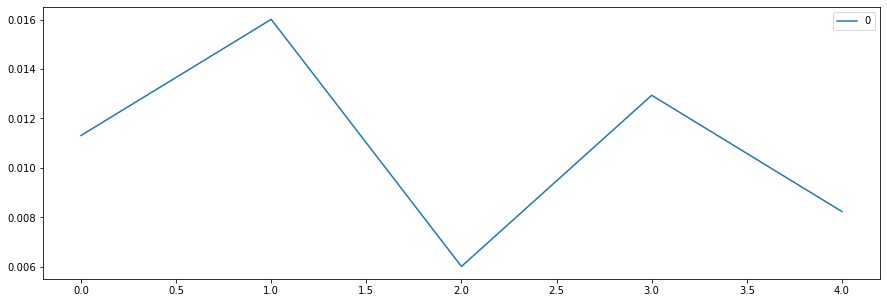

In [21]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(arma_results.forecast(steps=5)[0]).plot(figsize = (15,5))

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [22]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
## I need to import ARIMA.

from statsmodels.tsa.arima_model import ARIMA

In [23]:
## Now I need to define an arima_model using order=(5,1,1), from the instructions.
arima_model = ARIMA(yen_futures["Settle"].values, order=(5, 1, 1))

In [24]:
# Fit the model
arima_results = arima_model.fit()

In [25]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                10041
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -55213.364
Method:                       css-mle   S.D. of innovations             59.137
Date:                Thu, 08 Jul 2021   AIC                         110442.728
Time:                        14:43:28   BIC                         110500.444
Sample:                             1   HQIC                        110462.261
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4945      0.562      0.879      0.379      -0.608       1.597
ar.L1.D.y      0.2625      0.589      0.446      0.656      -0.892       1.417
ar.L2.D.y     -0.0026      0.013     -0.209      0.834      -0.027       0.022
ar.L3.D.y     -0.0052      0.011     -0.478      0.633      -0.027       0.016
ar.L4.D.y     -0.0135      0.011     -1.221      0.222      -0.035       0.008
ar.L5.D.y     -0.0020      0.014     -0.138      0.890      -0.030       0.026
ma.L1.D.y     -0.2751      0.589     -0.467      0.641      -1.430       0.879
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9355           -1.3678j            2.3700           -0.0979
AR.2            1.9355           +1.3678j            2.3700            0.0979
AR.3           -1.8248           -3.0692j            3.5707           -0.3354
AR.4           -1.8248           +3.0692j            3.5707            0.3354
AR.5           -7.1245           -0.0000j            7.1245           -0.5000
MA.1            3.6353           +0.0000j            3.6353            0.0000
-----------------------------------------------------------------------------
"""

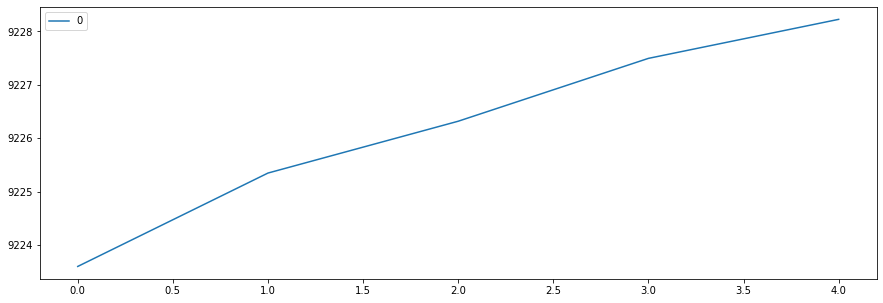

In [26]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(figsize = (15,5))

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [27]:
#### NOTE:  we're making a "GARCH" model, but not importing "garch", and I spent an hour trying to make this work before finding the solution on Google!
## The starter code just had "import arch", which didn't work (and the solution wasn't "import garch").
## I'm doing a pip install now.

!pip install arch

  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)


In [28]:
## That worked. Trying imports again.

import arch 
from arch import arch_model

In [29]:
## It worked!

In [30]:
# Estimate a GARCH model:
garch_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

In [31]:
# Fit the model
## as above ...
garch_results = garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 18057.251475614845
Iteration:      2,   Func. Count:     16,   Neg. LLF: 15339.809552807947
Iteration:      3,   Func. Count:     24,   Neg. LLF: 10203.204345015301
Iteration:      4,   Func. Count:     30,   Neg. LLF: 10288.785240024274
Iteration:      5,   Func. Count:     36,   Neg. LLF: 10180.181494418377
Iteration:      6,   Func. Count:     41,   Neg. LLF: 10172.375655739614
Iteration:      7,   Func. Count:     46,   Neg. LLF: 10172.388660254359
Iteration:      8,   Func. Count:     52,   Neg. LLF: 10172.185932799335
Iteration:      9,   Func. Count:     57,   Neg. LLF: 10172.18581422462
Iteration:     10,   Func. Count:     62,   Neg. LLF: 5724963644.168846
Iteration:     11,   Func. Count:     73,   Neg. LLF: 10730.494986238602
Iteration:     12,   Func. Count:     83,   Neg. LLF: 10489.786019353305
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10172.185786866241
            Itera

In [32]:
# Summarize the model results
## as above ...
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10172.2
Distribution:                  Normal   AIC:                           20352.4
Method:            Maximum Likelihood   BIC:                           20381.2
                                        No. Observations:                10041
Date:                Thu, Jul 08 2021   Df Residuals:                    10041
Time:                        14:43:33   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.8061e-03  4.349e-03      1.565      0.118 [-1.718e-03,1.533e-02]
alpha[1]       0.0417  1.451e-02      2.874  4.053e-03  [1.326e-02,7.015e-02]
alpha[2]   4.0045e-13  2.099e-02  1.907e-11      1.000 [-4.115e-02,4.115e-02]
beta[1]        0.9450  2.411e-02     39.197      0.000      [  0.898,  0.992]
=============================================================================

Covariance estimator: robust
"""

In [33]:
# Find the last day of the dataset
## This was in the starter code.

last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [34]:
# Create a 5 day forecast of volatility
## This was in the starter code.

forecast_horizon = 5

In [35]:
# Start the forecast using the last_day calculated above

forecasts = garch_results.forecast(start=last_day, horizon=forecast_horizon)

In [36]:
# Annualize the forecast
## This was in the starter code.

intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.728226,7.787522,7.84559,7.902466,7.958187


In [37]:
# Transpose the forecast so that it is easier to plot
## This was in the starter code.

final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.728226
h.2,7.787522
h.3,7.845590
h.4,7.902466
h.5,7.958187


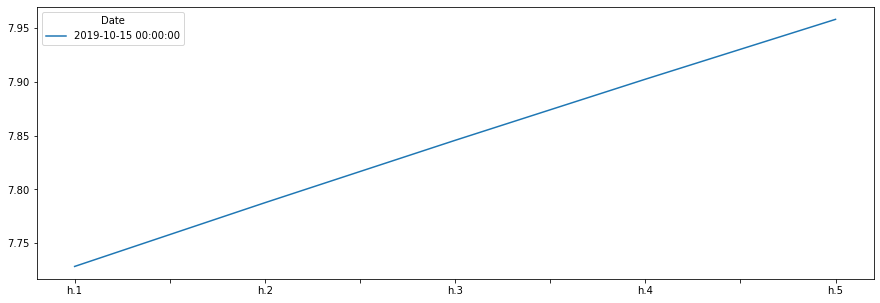

In [38]:
# Plot the final forecast
## Using the df named "final" created by the starter code, above.

final.plot(figsize=(15,5))

---

# Conclusions

In [39]:
# Q. Based on your time series analysis, would you buy the yen now?
## My understanding of AIC and BIC has led me to believe that lower values are better, and these seem high on all models.
## That said, the yen trend graph has been clearly upward from 2015-2020, so I would be comfortable investing *SOME* money into yen.

In [40]:
# Q. Is the risk of the yen expected to increase or decrease?
## It appears set to increase.

In [41]:
# Q. Based on the model evaluation, would you feel confident in using these models for trading?
## No-- again, the AIC and BIC values seem high, and I don't understand enough about these for big, "YOLO" investments.